In [1]:
import itertools
import gc
from bib import *
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K 
from keras import  activations
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Dense, Activation, regularizers,Flatten,BatchNormalization,Dropout,Reshape,Conv1D,MaxPooling1D
import tensorflow as tf
from  tqdm import tqdm_notebook
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
eps=np.finfo(np.float32).eps
xtrains,ytrains,xvals,yvals,xtest,ytest=split(('CHL 1','THERM 1','SSH','SR','WS'),
                                               ['CHL '+ str(i) for i in range(2,19)])
ytrains,yvals,ytest=applyToy(lambda x:np.log(x)/np.log(10),ytrains,yvals,ytest)

In [7]:
def custom_activation(x):
    return K.exp( x * np.log(10)+eps)+eps
get_custom_objects().update({'custom_activation': Activation(custom_activation)})
def generate(arch,act):
    layers=[]
    for index,size in enumerate(arch):
        if index ==0:
            layers.append(Dense(size, input_shape=(5,),activation=act[index]))
#             layers.append(BatchNormalization())

        else:
            layers.append(Dense(size,activation=act[index]))
#             layers.append(Dropout(0.3))
    layers.append(Reshape((9*17,13)))
    layers.append(Conv1D(10, 9,padding="same", activation="softplus"))
    layers.append(MaxPooling1D(pool_size=3))
    layers.append(Conv1D(5, 9,padding="same", activation="softplus"))
    layers.append(MaxPooling1D(pool_size=3))
    layers.append(Conv1D(1, 9,padding="same", activation="softplus"))
    layers.append(Flatten())
    layers.append(Dense(17,activation='linear',kernel_regularizer=regularizers.l2(0.01)))
    model = Sequential(layers)
    model.compile(optimizer='Adam',
              loss='mse')
    return model
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]

In [5]:
model=Sequential()
model.add(Dense(1989,input_shape=(5,)))
model.add(Reshape((9*17,13)))
model.add(Conv1D(10, 9,padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(5, 9,padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(1, 9,padding="same", activation="relu"))
model.add(Flatten())
model.add(Dense(17))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1989)              11934     
_________________________________________________________________
reshape_1 (Reshape)          (None, 153, 13)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 153, 10)           1180      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 5)             455       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 5)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 1)             46        
__________

In [8]:
def validate(arch,act,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    for xt,yt,xv,yv in tqdm_notebook(zip(xtrains,ytrains,xvals,yvals),total=len(xtrains)):
        model=generate(arch,act)
        
        mean=xt.mean()
        std=xt.std()
        
        xt=(xt-mean)/std
        xv=(xv-mean)/std
        
        
#         yt=np.exp(yt*np.log(10))-eps
#         yv=np.exp(yv*np.log(10))-eps
        
        
        model.fit(xt.values,yt.values,
                  epochs=10000,
                  callbacks=callbacks,
                  verbose=0,
                  batch_size=73*10, 
                  validation_data=(xv.values,yv.values))
        
        yp = model.predict(xv.values)
        
        #check error in original space
        
        yp=np.exp(yp*np.log(10))
        yv=np.exp(yv*np.log(10))       
        fold_evaluation.append(evaluate(yp,yv))
        print(evaluate(yp,yv))
        
    return np.mean(fold_evaluation),np.std(fold_evaluation )


In [9]:
arch=(1000, 500, 1000, 1989)
K.clear_session()
print('ARCH :'+ str(arch))
# print('ACT :'+ str(act))
error,std=validate(arch,['softplus']*len(arch),xtrains,ytrains,xvals,yvals)
print('\t error: %.5f +- %.5f' % (error,std))

ARCH :(1000, 500, 1000, 1989)
0.05749973067225114
0.06269978456358383
0.06251971524443703
0.1232527035355891
0.09911122908754745
0.06923647992084249
0.047203294914988536
0.06895274434759027
0.04322989312331051
0.05892439193114996
0.039532144734603675
0.05721187882445489
0.043538383232931736
0.04287749087598709
0.07597304648565656
0.04802585388136062

	 error: 0.06249 +- 0.02158


ARCH :(1000, 500, 1000, 1989)
error: 0.06249 +- 0.02158


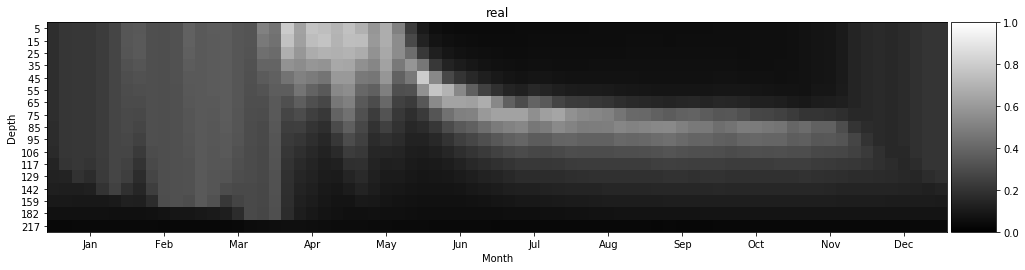

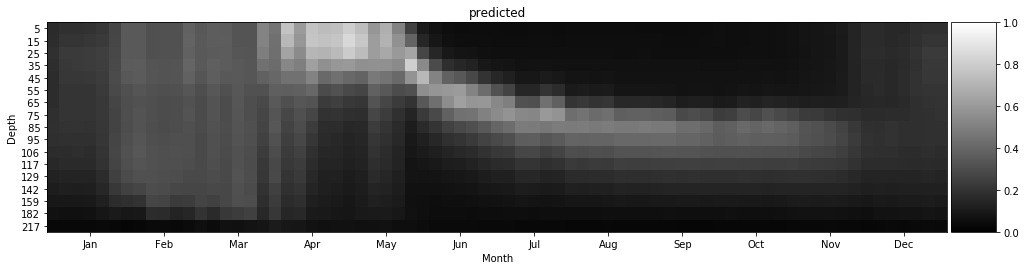

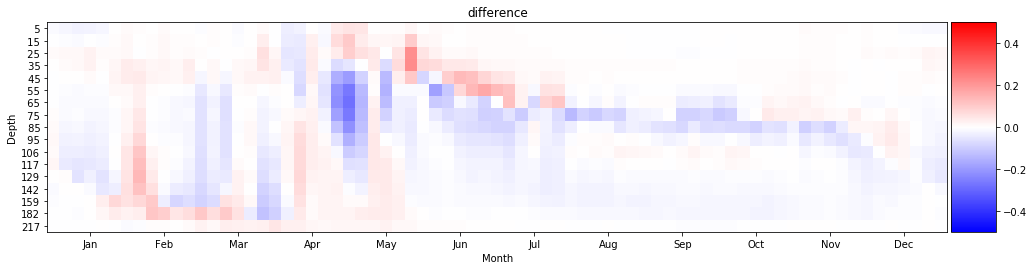

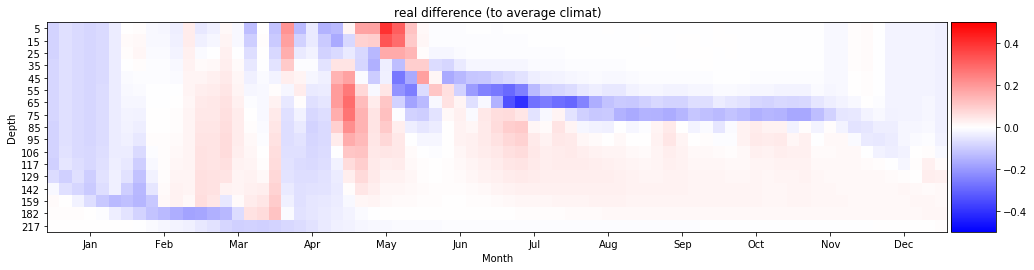

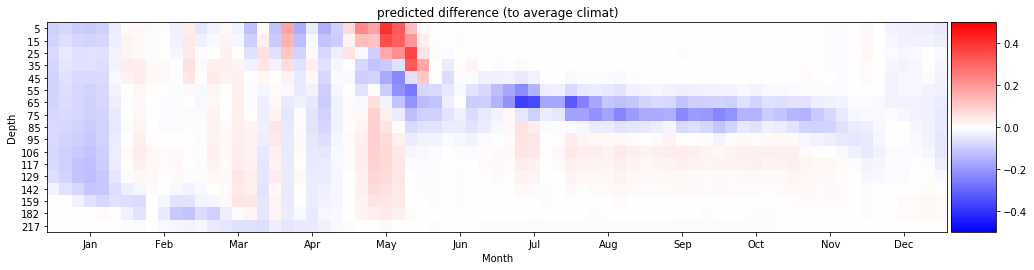

In [10]:
model=generate((1000, 500, 1000, 1989),['softplus']*4)
mean=xtrains[0].mean()
std=xtrains[0].std()

xt=(xtrains[0]-mean)/std
xv=(xvals[0]-mean)/std

model.fit(xt.values,ytrains[0].values,
          epochs=10000,
          callbacks=callbacks,
          verbose=0,
          batch_size=73*10, 
          validation_data=(xv.values,yvals[0].values))
xt=(xtest-mean)/std
yp = model.predict(xt.values)


yp=np.exp(yp*np.log(10))
yt=np.exp(ytest*np.log(10)).values


plotYear(yt,title='real')
plotYear(yp,title='predicted')
plotYear(yp-yt,title='difference',c='bwr',d=True)
climato(yt,title='real difference (to average climat)')
climato(yp,title='predicted difference (to average climat)')